### 분류 vs 군집

#### 분류모델
- 지도학습 : 정답 필요, 카테고리 명확
- 결정 트리 모델 : 랜덤 포레스트

#### 군집모델
- 비지도학습 : 정답 불필요, 무엇을 분류해야할지 모름
- k-평균 클러스터링

### 0. 클러스터링 : 비지도 학습(정답 없음)
>- 사람들이 구매하고 싶은 과일 사진을 보내는데 가장 많이 요청하는 과일 목록을 지정.
>- 데이터 : 사람들이 보낸 과일 사진
>    - 정답이 없으므로 분류 모델 사용할 수 없음

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1. 데이터 로드

In [2]:
fruits = np.load('./dataset/fruits_300.npy')

In [3]:
print(fruits.shape)

(300, 100, 100)


> 100 x 100 픽셀, 파인애플, 사과, 바나나 사진 각 100장씩 300장

- 그림 확인

In [4]:
print(fruits[0,0,:])

[  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   2   1
   2   2   2   2   2   2   1   1   1   1   1   1   1   1   2   3   2   1
   2   1   1   1   1   2   1   3   2   1   3   1   4   1   2   5   5   5
  19 148 192 117  28   1   1   2   1   4   1   1   3   1   1   1   1   1
   2   2   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1]


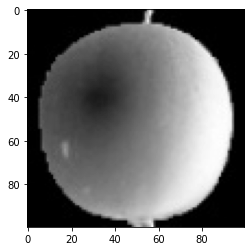

In [5]:
plt.imshow(fruits[0],cmap='gray')
plt.show()

> - 0 에 가까울수록 검은 픽셀
> - 모델 학습시 수치값 클수록 주목
> - 검은 색(배경) 학습하지 말라고 값 낮을수록 검게 하여 반전사진이 나옴

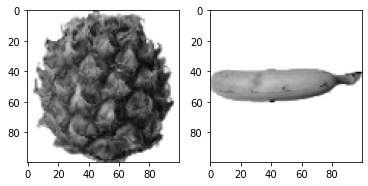

In [6]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(fruits[100], cmap='gray_r') #사진 반전하여 표시
axs[1].imshow(fruits[200], cmap='gray_r')

### 2. 픽셀값 분석하기

- 픽셀 평균값 계산해보기
    - 사과 100장 겹쳤을 때 각 픽셀의 평균 값 계산

- 100x100 사진을 10000개의 픽셀로 펼침

In [9]:
apple = fruits[0:100].reshape(-1,10000)
pineapple = fruits[100:200].reshape(-1,10000)
banana = fruits[200:300].reshape(-1,10000)

print(apple.shape)

(100, 10000)


> (100,100,100)에서 (100, 10000) 으로, 10000픽셀 100장.

- 사과 샘플 100개의 평균값 계산

In [11]:
print(apple.mean(axis=1))

[ 88.3346  97.9249  87.3709  98.3703  92.8705  82.6439  94.4244  95.5999
  90.681   81.6226  87.0578  95.0745  93.8416  87.017   97.5078  87.2019
  88.9827 100.9158  92.7823 100.9184 104.9854  88.674   99.5643  97.2495
  94.1179  92.1935  95.1671  93.3322 102.8967  94.6695  90.5285  89.0744
  97.7641  97.2938 100.7564  90.5236 100.2542  85.8452  96.4615  97.1492
  90.711  102.3193  87.1629  89.8751  86.7327  86.3991  95.2865  89.1709
  96.8163  91.6604  96.1065  99.6829  94.9718  87.4812  89.2596  89.5268
  93.799   97.3983  87.151   97.825  103.22    94.4239  83.6657  83.5159
 102.8453  87.0379  91.2742 100.4848  93.8388  90.8568  97.4616  97.5022
  82.446   87.1789  96.9206  90.3135  90.565   97.6538  98.0919  93.6252
  87.3867  84.7073  89.1135  86.7646  88.7301  86.643   96.7323  97.2604
  81.9424  87.1687  97.2066  83.4712  95.9781  91.8096  98.4086 100.7823
 101.556  100.7027  91.6098  88.8976]


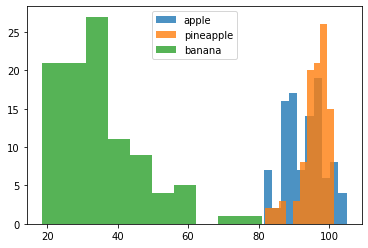

In [12]:
plt.hist(np.mean(apple,axis=1),alpha=0.8)
plt.hist(np.mean(pineapple,axis=1),alpha=0.8)
plt.hist(np.mean(banana,axis=1),alpha=0.8)
plt.legend(['apple','pineapple','banana'])
plt.show()

> - 바나나는 평균값이 40 아래에 집중, 사진이 차지하는 영역이 큰 사과와 파인애플은 90~100 사이에 집중
> - 바나나는 평균값만 보고 구별 가능

- 사진 실제로 겹쳐서 확인

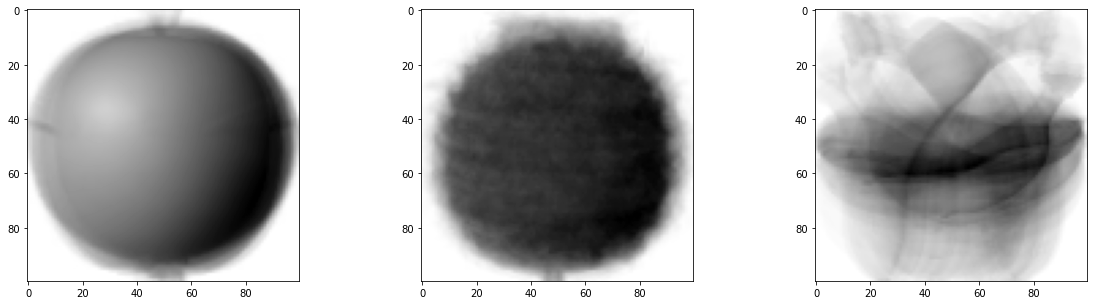

In [17]:
apple_mean = np.mean(apple,axis=0).reshape(100,100)
pineapple_mean = np.mean(pineapple,axis=0).reshape(100,100)
banana_mean = np.mean(banana,axis=0).reshape(100,100)

fig, axs = plt.subplots(1,3, figsize=(20,5))
axs[0].imshow(apple_mean, cmap = 'gray_r')
axs[1].imshow(pineapple_mean, cmap = 'gray_r')
axs[2].imshow(banana_mean, cmap = 'gray_r')
plt.show()

### 3. K-Means 클러스터링

- 비지도 학습(정답 x)
- 패턴을 분석하여 비슷한 것들끼리 군집을 묶음
  
    >1. 무작위로 k개의 클러스터 중심(센트로이드) 설정
    >2. 각 샘플에서 가장 가까운 클러스터로 중심을 찾아 해당 클러스터 샘플로 지정
    >3. 클러스터에 속한 샘플의 평균값으로 클러스터 중심 변경
    >4. 클러스터 중심에 변화가 없을 때까지 [2,3]번 반복

In [31]:
fruits = np.load('./dataset/fruits_300.npy') # (300,100,100)
fruits_2d = fruits.reshape(-1, 10000)        # (300,100000)  

In [35]:
from sklearn.cluster import KMeans

km=KMeans(n_clusters=3, random_state = 42)
km.fit(fruits_2d)

KMeans(n_clusters=3, random_state=42)

In [39]:
print(km.labels_)

[2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 0 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [37]:
print(np.unique(km.labels_,return_counts=True))

(array([0, 1, 2]), array([111,  98,  91], dtype=int64))


> 0번 1번 2번 그룹에 각각 111개 98개 91개가 클러스터링됨.

In [47]:
import matplotlib.pyplot as plt

def draw_fruits(arr,ratio=1):
    n = len(arr)
    rows = int(np.ceil(n/10))
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols,
                           figsize = (cols*ratio, rows*ratio),
                           squeeze = False)
    for i in range(rows):
        for j in range(cols):
            if i*10+j < n:
                axs[i,j].imshow(arr[i*10+j],cmap='grey_r')
            axs[i,j].axis('off')
    plt.show()

ValueError: 'grey_r' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

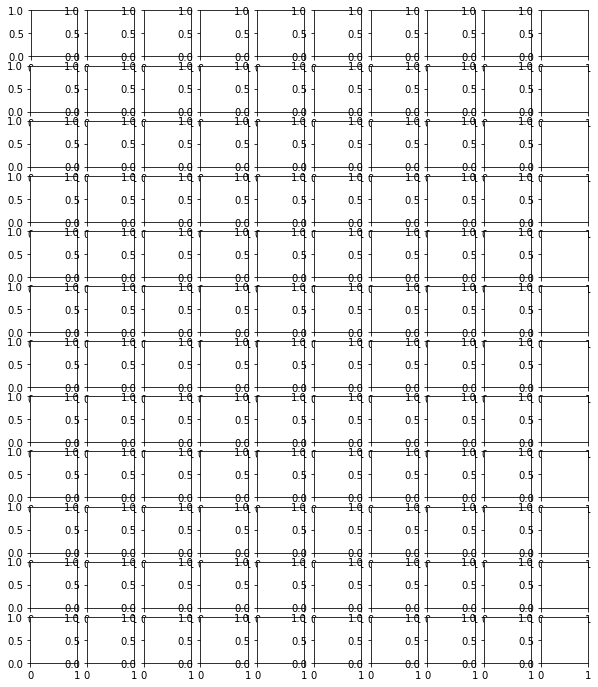

In [48]:
draw_fruits(fruits[km.labels_==0])

In [ ]:
draw_fruits(fruits[km.labels_==1])

In [ ]:
draw_fruits(fruits[km.labels_==2])

> 2번그룹에 사과, 바나나가 좀 섞임